In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0   0.393181 -0.889863 -1.324475  0.854999  0.297797 -0.120519  0.295236   
  1  -0.015590  0.002795 -0.677219 -0.013877 -0.292356  0.475081  0.225039   
  2  -0.037801 -0.478667 -0.957826  0.921463  0.825742  0.253482  1.069392   
  3  -0.927024 -0.552306 -1.428657  0.487599  0.752257  0.076594 -0.351944   
  4  -0.197135 -0.053101 -0.634565 -0.542953  0.373325 -0.565394  0.284756   
  5  -0.328446 -0.074483 -0.270022  0.030965 -0.523859  0.243441  0.068886   
  6   0.023495 -0.940395  0.028422  0.282038 -0.496299 -0.106657  1.089580   
  7  -0.112509  0.562254 -0.377989  0.544633  0.207223  0.902976  0.719013   
  8  -0.665221 -0.909876 -1.025849  0.166165 -0.490445 -0.454170  0.276120   
  9   0.109503  0.238203  0.535750  0.848227 -0.289927 -0.201926  0.218892   
  10  1.384452  0.602427 -1.166104 -0.171065 -1.015965 -0.609487  0.027321   
  11  0.630495  0.593673 -0.613880 -0.220136  0.730882  0.071572  0.398043   
  12  1.831187  0.423119 -0.237236 -0.312182 -0.081036 -0.474359  0.965317   
  13 -0.192104 -1.272739 -0.529606  0.234491  0.572124 -0.166407  0.141865   
  14 -0.389254 -0.017416 -1.083889 -1.572326 -0.895911  0.032237  0.272975   
  15 -1.241723  0.138930 -0.134720  0.187054 -0.217416 -0.334013  0.289019   
  16  0.458337 -0.812745 -0.833034 -0.510208  0.419773  0.990432  0.848231   
  17  0.193893  0.063585 -0.488132 -1.063468 -1.081738 -0.908357  0.178690   
  18  0.756571 -0.490582 -0.827087  0.761030 -0.133524  1.007022  0.979237   
  19  0.579607 -0.038880 -0.370077 -0.734754 -0.244736 -0.583183  0.452754   
  20  0.093504 -0.380385 -0.391961 -0.334359 -0.411706 -0.505253  0.691771   
  21  0.091476 -0.445667 -0.178191 -0.340278  0.816304  0.247997 -0.424525   
  22 -0.294537 -0.538625 -0.479623 -0.208237  0.090476 -0.270238  1.245306   
  23  0.711139  0.430542 -0.050314 -0.026784  0.683589  0.654417  0.303374   
  24 -0.759089 -0.322012 -0.590087  0.625986  0.176420 -0.340584  0.458497   
1 0  -0.297750  0.177844  0.630945  0.383954 -0.855471 -0.127721 -0.188422   
  1   0.884312  0.853037  0.337306  0.123194 -0.142409 -0.620449 -0.731538   
  2   0.537922  0.733209  0.374082 -0.031849 -0.352879  0.574651 -0.093954   
  3   0.146909 -0.048767 -0.000237  0.835455  0.416605  0.005390 -0.243793   
  4  -0.533917 -0.224722 -0.248483 -0.652187  1.048135  0.053283 -0.582809   

            X8        X9       X10  ...       X94       X95       X96  \
0 0   1.195351  1.343410 -0.373960  ... -0.411919  0.068987 -0.048141   
  1   0.092206  0.135781 -0.307225  ... -0.196827  0.288822 -0.378843   
  2  -0.365797 -0.265287  0.192936  ... -0.894344 -0.128200 -0.694520   
  3  -0.271760 -0.181214  0.494495  ... -0.543985  0.119841 -0.089134   
  4  -0.209258  0.063876 -0.202029  ... -0.389838  0.572422 -0.625754   
  5   0.728110  0.209561  0.026953  ... -1.258364 -0.254610  1.590913   
  6   0.622249  0.221741  0.055467  ... -0.299488  0.080875 -0.179959   
  7   1.030206  0.183172  0.560213  ... -0.859078 -0.115200 -0.345067   
  8  -0.070674  0.202076 -0.554923  ...  0.748461  0.849789  0.408962   
  9   0.857894  0.094209 -0.057781  ...  0.177891 -1.560910 -0.113211   
  10  0.764569  0.416805 -0.194177  ... -1.198906 -0.860866  0.192627   
  11  0.376920  1.195656 -0.473871  ...  0.972493  0.766870  1.277939   
  12  1.014312  0.713606  0.180087  ... -0.007986 -0.039226 -0.296846   
  13 -0.189528 -1.104081 -0.419710  ... -0.284003 -0.312047 -0.690339   
  14  0.485373  0.225430 -0.188132  ... -0.388360 -0.947639  0.088552   
  15  0.167867  0.011598  0.215560  ... -0.076017 -0.225793  0.148228   
  16  0.405893  0.679465 -0.674477  ... -0.128272  0.120551  0.134469   
  17  0.943648  0.066652  0.565304  ...  0.127687  0.635841  0.479767   
  18  0.932840  0.529116  0.641724  ...  0.458411 -0.227424 -0.741668   
  19 -0.507877  0.428964 -0.375519  ...  0.773839 -0.297003  0.173860   
  20 -0.552305 -0.082217 -0.731830  ... -0.468676  0.482467 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
D  1.102508  0.032932  33.478619  9.868704e-246  1.037963  1.167053


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



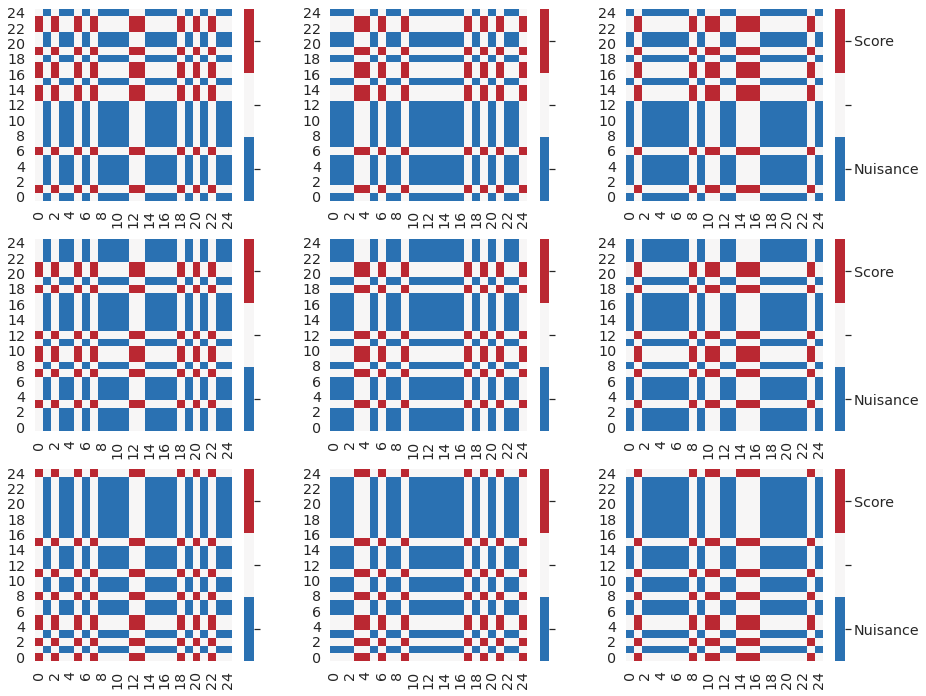

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



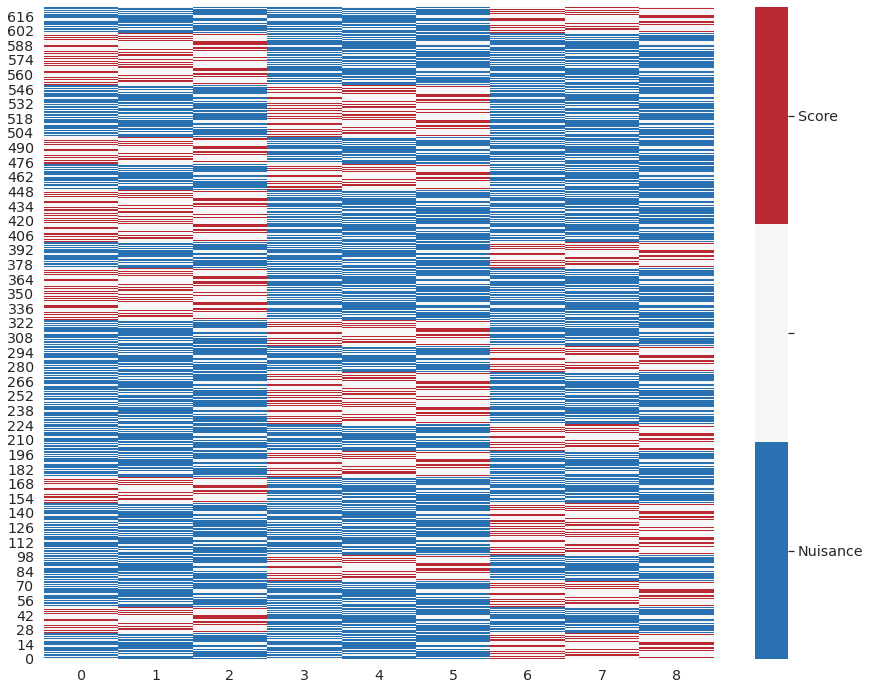

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])